# Conjoint Analysis for Sensory Data

This notebook demonstrates **conjoint analysis**, a statistical technique used to understand how consumers value different attributes of a product. Conjoint analysis helps identify which product features drive consumer preferences and how much each attribute contributes to overall liking.

**What is Conjoint Analysis?**
- A method to decompose consumer preferences into part-worth utilities for different attribute levels
- Helps identify which product attributes are most important
- Useful for product optimization and market research

**Learning Objectives:**
- Understand the concept of part-worth utilities
- Perform ratings-based conjoint analysis
- Calculate attribute importance from descriptive data
- Visualize attribute contributions to product liking
- Interpret conjoint analysis results

---

## Installation Instructions

Before running this notebook, make sure you have the required packages installed. Run the following command in your terminal or command prompt:

```bash
pip install pandas numpy patsy statsmodels scikit-learn matplotlib openpyxl
```

**Note:** `openpyxl` is required to read Excel files (`.xls` and `.xlsx` formats).

If you're using Anaconda, you can also install using conda:
```bash
conda install pandas numpy patsy statsmodels scikit-learn matplotlib openpyxl
```


## 1. Import Required Libraries

We will import all necessary libraries for data manipulation, statistical modeling, and visualization.



In [1]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Statistical modeling
import patsy  # For creating design matrices
import statsmodels.api as sm  # For regression models

# Machine learning (for attribute importance)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Custom colors for visualizations (optional)
illiniorange = "#FF5F05"
illiniblue = "#13294B"


## 2. Load and Explore Data

We'll load the consumer data from an Excel file. This dataset contains consumer ratings for white corn tortilla chips, including liking scores, JAR (Just-About-Right) ratings, and purchase intent.


In [2]:

# Load consumer data from Excel file
# Sheet 0 contains consumer ratings
chips = pd.read_excel("data/White Corn Tortilla Chips.xls", sheet_name=0)

# Select relevant columns for analysis
chips = chips[["Product", "ProductID", "panID",
               "Liking", "Appearance", "Flavor", "Texture",
               "Saltiness JAR", "PurchaseIntent"]].copy()

# Remove rows with missing values in key variables
chips = chips.dropna(subset=["Liking", "Saltiness JAR", "PurchaseIntent"])

print("Dataset shape:", chips.shape)
print("\nFirst few rows:")
print(chips.head())



Dataset shape: (879, 9)

First few rows:
  Product ProductID  panID  Liking Appearance Flavor Texture Saltiness JAR  \
0    P542       BYW      1       8          6      7       7             3   
1    P225       GMG      1       3          8      3       4             1   
2    P331       GUY      1       6          4      5       8             2   
3    P961       MED      1       3          4      2       4             1   
4    P580       MST      1       9          9      9       9             3   

  PurchaseIntent  
0              4  
1              1  
2              3  
3              1  
4              5  


### 2.1. Data Description

Let's examine the basic statistics and data types to understand our dataset better.


In [3]:
# Display descriptive statistics
print("Descriptive Statistics:")
print("="*60)
print(chips.describe())

print("\n" + "="*60)
print("Data Types:")
print(chips.dtypes)


Descriptive Statistics:
           panID      Liking
count  879.00000  879.000000
mean    40.45620    6.292378
std     23.08191    1.890469
min      1.00000    1.000000
25%     20.50000    5.000000
50%     40.00000    7.000000
75%     60.00000    8.000000
max     80.00000    9.000000

Data Types:
Product           object
ProductID         object
panID              int64
Liking             int64
Appearance        object
Flavor            object
Texture           object
Saltiness JAR     object
PurchaseIntent    object
dtype: object


## 3. Prepare Data for Conjoint Analysis

For conjoint analysis, we need to:
1. Convert JAR (Just-About-Right) ratings into categorical attribute levels
2. Ensure numeric variables are properly formatted
3. Create attribute levels that represent different product characteristics

**JAR Scale Interpretation:**
- Ratings 1-2: Too low (not enough saltiness)
- Rating 3: Just right (optimal saltiness)
- Ratings 4-5: Too high (too much saltiness)


In [4]:
# Convert Saltiness JAR to numeric (handles any text values)
chips["Saltiness JAR"] = pd.to_numeric(chips["Saltiness JAR"], errors='coerce')

# Recode JAR saltiness into 3 categorical levels
# Bins: 1-2 = too_low, 3 = just_right, 4-5 = too_high
chips["salt_level"] = pd.cut(
    chips["Saltiness JAR"],
    bins=[0, 2, 3, 5],
    labels=["too_low", "just_right", "too_high"],
    right=True,
    include_lowest=True
)

# Ensure PurchaseIntent is numeric
chips["PurchaseIntent"] = pd.to_numeric(chips["PurchaseIntent"], errors='coerce')

# Convert Product to categorical for potential use as a factor
chips["Product"] = chips["Product"].astype("category")

# Display summary
print("Sample of prepared data:")
print(chips[["Product", "Liking", "Saltiness JAR", "salt_level", "PurchaseIntent"]].head())
print("\n" + "="*60)
print("Distribution of saltiness levels:")
print(chips["salt_level"].value_counts().sort_index())
print("\nNumber of unique products:", chips["Product"].nunique())


Sample of prepared data:
  Product  Liking  Saltiness JAR  salt_level  PurchaseIntent
0    P542       8            3.0  just_right             4.0
1    P225       3            1.0     too_low             1.0
2    P331       6            2.0     too_low             3.0
3    P961       3            1.0     too_low             1.0
4    P580       9            3.0  just_right             5.0

Distribution of saltiness levels:
salt_level
too_low       328
just_right    423
too_high      127
Name: count, dtype: int64

Number of unique products: 11


## 4. Ratings-Based Conjoint Model

In ratings-based conjoint analysis, we model consumer liking as a function of product attributes. This allows us to estimate **part-worth utilities** - the contribution of each attribute level to overall liking.

**Model Structure:**
- **Dependent variable**: Liking (consumer preference rating)
- **Independent variables**: 
  - Saltiness level (categorical: too_low, just_right, too_high)
  - Purchase Intent (continuous predictor)

**Part-worth utilities** represent how much each attribute level contributes to liking. Higher utilities indicate greater preference.


In [5]:
# Define the regression formula
# C(salt_level, Sum) uses sum coding for the categorical variable
# This means coefficients represent deviations from the overall mean
formula = "Liking ~ C(salt_level, Sum) + PurchaseIntent"

# Create design matrices using patsy
# This converts the formula into matrices suitable for regression
y, X = patsy.dmatrices(formula, data=chips, return_type="dataframe")

# Fit the Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

# Display model summary
print("Conjoint Analysis Model Results:")
print("="*60)
print(model.summary())


Conjoint Analysis Model Results:
                            OLS Regression Results                            
Dep. Variable:                 Liking   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     556.7
Date:                Thu, 01 Jan 2026   Prob (F-statistic):          3.83e-202
Time:                        13:14:10   Log-Likelihood:                -1334.3
No. Observations:                 877   AIC:                             2677.
Df Residuals:                     873   BIC:                             2696.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## 5. Calculate Part-Worth Utilities

Part-worth utilities show the relative preference for each attribute level. We calculate utilities by predicting liking scores for each saltiness level while holding other variables (like Purchase Intent) constant at their mean values.

**Interpretation:**
- Higher utility = greater preference
- The range of utilities shows how much the attribute matters
- Utilities are relative, not absolute values


In [6]:
# Extract model coefficients
coef = model.params
levels = chips["salt_level"].cat.categories
pw = {}  # Dictionary to store part-worth utilities

# Set PurchaseIntent to its mean value for fair comparison
pi_mean = chips["PurchaseIntent"].mean()

# Calculate part-worth utility for each saltiness level
for lev in levels:
    # Create a temporary dataframe with one saltiness level
    tmp_df = pd.DataFrame({
        "salt_level": pd.Categorical([lev], categories=levels),
        "PurchaseIntent": [pi_mean]
    })
    # Create design matrix for predictors only (no response variable)
    X_tmp = patsy.dmatrix(formula.split("~")[1], data=tmp_df, return_type="dataframe")
    # Calculate utility: multiply design matrix by coefficients
    pw[lev] = float(np.dot(X_tmp.iloc[0].values, coef.values))

# Display part-worth utilities
print("Part-Worth Utilities for Saltiness Levels:")
print("="*60)
for lev, val in pw.items():
    print(f"{lev:15s}: {val:.3f}")

# Calculate the range (importance) of saltiness attribute
salt_range = max(pw.values()) - min(pw.values())
print(f"\nPart-worth range (saltiness importance): {salt_range:.3f}")
print("\nInterpretation:")
print("- Higher utility = greater preference")
print("- Larger range = attribute has more impact on liking")


Part-Worth Utilities for Saltiness Levels:
too_low        : 6.128
just_right     : 6.406
too_high       : 6.342

Part-worth range (saltiness importance): 0.278

Interpretation:
- Higher utility = greater preference
- Larger range = attribute has more impact on liking


### 5.1. Interpretation of Results

Based on the part-worth utilities calculated above, we can interpret consumer preferences:

- **"Just right"** typically has the highest utility, indicating consumers prefer optimal saltiness
- **"Too low"** and **"Too high"** have lower utilities, showing penalties for non-optimal levels
- The **range** of utilities indicates how much saltiness matters relative to other attributes

For more information on interpreting part-worth utilities, see [this guide](https://conjointly.com/guides/how-to-interpret-partworth-utilities/).


## 6. Visualize Part-Worth Utilities

Let's create a visualization to better understand the part-worth utilities for saltiness levels.


Part-Worth Utilities DataFrame:
   Attribute       Level  Preference
0  Saltiness     too_low    6.127842
1  Saltiness  just_right    6.405749
2  Saltiness    too_high    6.342489


/var/folders/cx/_v080m5s5757ktxy0dsp15tr0000gn/T/ipykernel_16682/1550827151.py:21: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  X_tmp = patsy.dmatrix(X.design_info.builder, tmp_df, return_type="dataframe")
/var/folders/cx/_v080m5s5757ktxy0dsp15tr0000gn/T/ipykernel_16682/1550827151.py:21: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  X_tmp = patsy.dmatrix(X.design_info.builder, tmp_df, return_type="dataframe")
/var/folders/cx/_v080m5s5757ktxy0dsp15tr0000gn/T/ipykernel_16682/1550827151.py:21: DeprecationWarning: The DesignInfo.builder attribute is dep

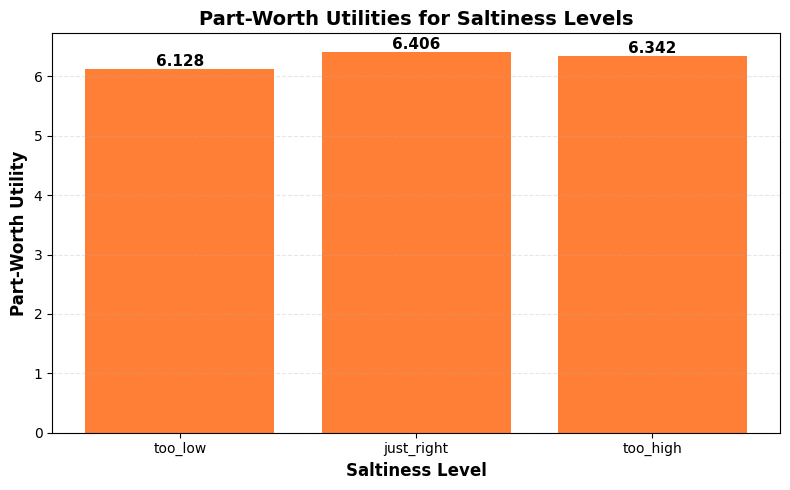

In [7]:
# Prepare data for visualization
# Recalculate utilities in a format suitable for plotting
formula = "Liking ~ C(salt_level, Sum) + PurchaseIntent"
y, X = patsy.dmatrices(formula, data=chips, return_type="dataframe")
model = sm.OLS(y, X).fit()
coef = model.params

levels = chips["salt_level"].cat.categories
mean_pi = chips["PurchaseIntent"].mean()

# To compute the utility for each saltiness level, align the number of columns!
# Use the same columns as the original X in the model
rows = []
for lev in levels:
    tmp = {
        "salt_level": pd.Categorical([lev], categories=levels),
        "PurchaseIntent": [mean_pi]
    }
    tmp_df = pd.DataFrame(tmp)
    # Construct the dmatrix using the same formula (including intercept), and ensure columns match
    X_tmp = patsy.dmatrix(X.design_info.builder, tmp_df, return_type="dataframe")
    # Now np.dot will work since columns align
    utility = float(np.dot(X_tmp.iloc[0].values, coef.values))
    rows.append({"Attribute": "Saltiness",
                 "Level": lev,
                 "Preference": utility})

pw_df = pd.DataFrame(rows)
print("Part-Worth Utilities DataFrame:")
print(pw_df)

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(pw_df["Level"], pw_df["Preference"], color=illiniorange, alpha=0.8)
plt.xlabel("Saltiness Level", fontsize=12, weight='bold')
plt.ylabel("Part-Worth Utility", fontsize=12, weight='bold')
plt.title("Part-Worth Utilities for Saltiness Levels", fontsize=14, weight='bold')
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()


Within the conjoint-style analysis of the white corn tortilla chips data, the estimated part‑worth utilities for perceived saltiness were 6.13 for “too low,” 6.41 for “just right,” and 6.34 for “too high,” with a total range of about 0.28 liking units on the 9‑point scale. This pattern indicates that consumers clearly favor chips they perceive as “just-about-right” salty, with a penalty when saltiness is judged too low and a smaller, but still detectable, penalty when it is perceived as too high. In conjoint terms, the relatively modest utility range suggests that, while saltiness is a meaningful driver of liking, it is unlikely to be the sole determinant of product preference and should be optimized in combination with other sensory attributes such as flavor and texture.

More information on inferring partworth utilities is provided [here](https://conjointly.com/guides/how-to-interpret-partworth-utilities/)


### 7.1. Load Descriptive Profile Data

We need to load the descriptive profile data (from trained panelists) and merge it with consumer liking scores.

In [8]:
# Load descriptive profile data (Sheet 1 contains trained panelist ratings)
descrip = pd.read_excel("data/White Corn Tortilla Chips.xls", sheet_name=1)

# Calculate mean liking for each product from consumer data
prod_liking = (chips
               .groupby("ProductID")["Liking"]
               .mean()
               .reset_index()
               .rename(columns={"Liking": "MeanLiking"}))

# Merge consumer liking with descriptive attributes
prod_df = pd.merge(prod_liking, descrip, on="ProductID")

print(f"Number of products: {len(prod_df)}")
print(f"Number of descriptive attributes: {len(descrip.columns) - 1}")  # -1 for ProductID
print("\nFirst few rows of merged data:")
print(prod_df.head())


Number of products: 11
Number of descriptive attributes: 37

First few rows of merged data:
  ProductID  MeanLiking    sweet     salt     sour     lime  astringent  \
0       BYW      6.3875  0.46875  8.75625  0.04370  0.00000     2.55000   
1       GMG      5.4625  0.50588  7.22353  0.14118  0.21765     2.44706   
2       GUY      5.8875  0.52941  7.84118  0.09410  0.00000     2.52353   
3       MED      5.2750  0.43529  6.88235  0.10000  0.00000     2.52941   
4       MST      6.2625  0.62941  9.44118  0.08820  0.00000     2.65294   

   graincomplex  toastedcorn  rawcorn  ...  persistcrisp  toothpack  \
0       6.90000      2.71875  0.00000  ...      6.000000   5.211765   
1       7.21176      2.25294  0.17647  ...      5.176471   5.205883   
2       6.62353      1.62353  0.00000  ...      5.058824   5.100000   
3       6.47059      2.29412  0.00000  ...      5.529412   5.205883   
4       7.08235      3.81765  0.00000  ...      4.941176   5.370588   

   looseparticles1  oilygreasy

### 7.2. Prepare Attributes and Fit Regression Model

We will use all 37 descriptive attributes to predict mean product liking. Standardizing the variables ensures that coefficients are comparable and represent relative importance.


In [9]:
# List of all 37 descriptive attributes
attrs = [
    "sweet","salt","sour","lime","astringent","graincomplex",
    "toastedcorn","rawcorn","masa","toastedgrain","painty",
    "feedy","heatedoil","scorched","cardboard","sourgrain",
    "microrough","macrorough","oilygreasylip","looseparticles",
    "hardness","crispness","fracturability","cohesivemass",
    "roughofmass","moistofmass","moistabsorp","persistcrisp",
    "toothpack","looseparticles1","oilygreasyfilm",
    "DegreeofWhiteness","GrainFlecks","CharMarks",
    "MicroSurfaceParticles","AmountofBubbles","spots"
]

# Extract predictor variables (attributes) and response (mean liking)
X = prod_df[attrs].values
y = prod_df["MeanLiking"].values

# Standardize both predictors and response
# This makes coefficients comparable across attributes with different scales
scaler_X = StandardScaler()
X_z = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_z = scaler_y.fit_transform(y.reshape(-1,1)).ravel()

# Fit linear regression model
model = LinearRegression()
model.fit(X_z, y_z)

# Extract coefficients (these represent attribute importance)
coef = model.coef_

print(f"Model fitted with {len(attrs)} attributes")
print(f"R² score: {model.score(X_z, y_z):.3f}")


Model fitted with 37 attributes
R² score: 1.000


### 7.3. Calculate and Visualize Attribute Importance

We calculate relative importance by taking the absolute value of coefficients and normalizing them to sum to 1. This shows which attributes contribute most to consumer liking.


In [10]:
# Calculate relative importance
# Take absolute value of coefficients (direction doesn't matter for importance)
importance = np.abs(coef)
# Normalize to sum to 1.0 (represents proportion of total importance)
importance = importance / importance.sum()

# Create dataframe with importance values
imp_df = pd.DataFrame({
    "Attribute": attrs,
    "Importance": importance
}).sort_values("Importance", ascending=False)


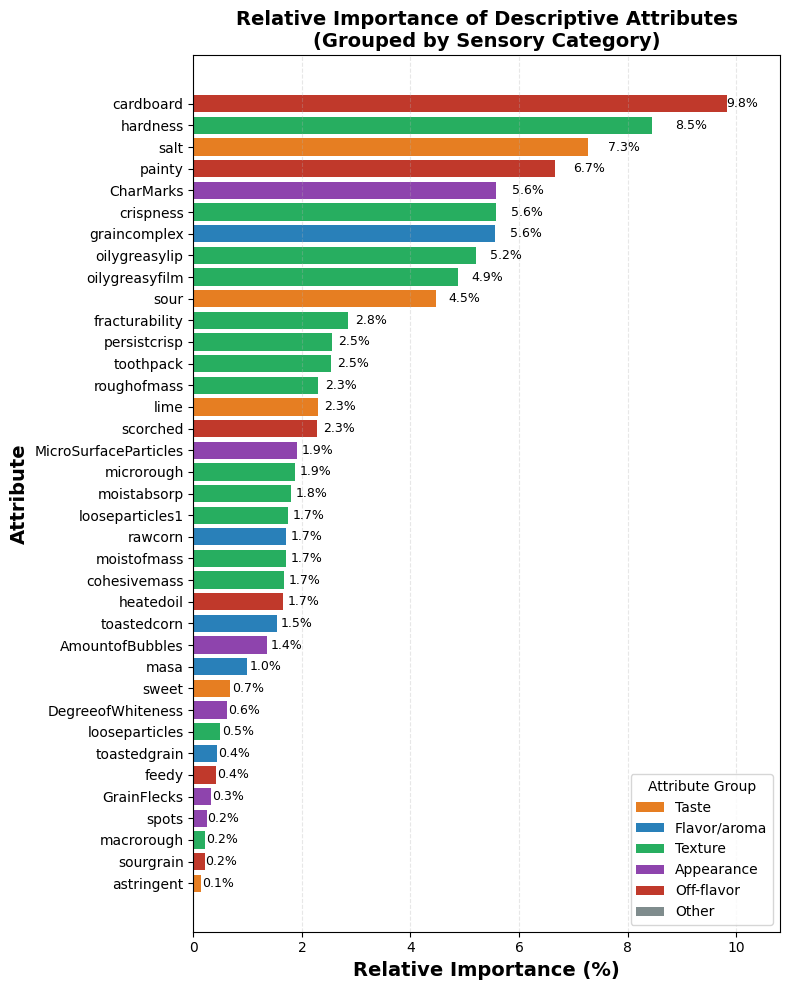


Importance Summary by Attribute Group:
Texture             :  43.8%
Off-flavor          :  21.0%
Taste               :  14.9%
Flavor/aroma        :  10.2%
Appearance          :  10.0%


In [11]:
# Convert importance to percentages
imp_df["Importance_pct"] = imp_df["Importance"] * 100

# Define attribute groups for color coding
group_map = {
    "sweet": "Taste",
    "salt": "Taste",
    "sour": "Taste",
    "lime": "Taste",
    "astringent": "Taste",
    "graincomplex": "Flavor/aroma",
    "toastedcorn": "Flavor/aroma",
    "rawcorn": "Flavor/aroma",
    "masa": "Flavor/aroma",
    "toastedgrain": "Flavor/aroma",
    "painty": "Off-flavor",
    "feedy": "Off-flavor",
    "heatedoil": "Off-flavor",
    "scorched": "Off-flavor",
    "cardboard": "Off-flavor",
    "sourgrain": "Off-flavor",
    "microrough": "Texture",
    "macrorough": "Texture",
    "oilygreasylip": "Texture",
    "looseparticles": "Texture",
    "hardness": "Texture",
    "crispness": "Texture",
    "fracturability": "Texture",
    "cohesivemass": "Texture",
    "roughofmass": "Texture",
    "moistofmass": "Texture",
    "moistabsorp": "Texture",
    "persistcrisp": "Texture",
    "toothpack": "Texture",
    "looseparticles1": "Texture",
    "oilygreasyfilm": "Texture",
    "DegreeofWhiteness": "Appearance",
    "GrainFlecks": "Appearance",
    "CharMarks": "Appearance",
    "MicroSurfaceParticles": "Appearance",
    "AmountofBubbles": "Appearance",
    "spots": "Appearance",
}

# Assign groups and colors
imp_df["Group"] = imp_df["Attribute"].map(group_map).fillna("Other")

group_colors = {
    "Taste": "#e67e22",        # Orange
    "Flavor/aroma": "#2980b9",  # Blue
    "Texture": "#27ae60",       # Green
    "Appearance": "#8e44ad",    # Purple
    "Off-flavor": "#c0392b",    # Red
    "Other": "#7f8c8d",         # Gray
}

imp_df["Color"] = imp_df["Group"].map(group_colors)

# Sort by importance for plotting
imp_df = imp_df.sort_values("Importance_pct", ascending=True)
max_val = imp_df["Importance_pct"].max()

# Create grouped bar plot
plt.figure(figsize=(8, 10))
bars = plt.barh(imp_df["Attribute"],
                imp_df["Importance_pct"],
                color=imp_df["Color"])

plt.xlabel("Relative Importance (%)", fontsize=14, fontweight="bold")
plt.ylabel("Attribute", fontsize=14, fontweight="bold")
plt.title("Relative Importance of Descriptive Attributes\n(Grouped by Sensory Category)", 
          fontsize=14, fontweight="bold")

# Set x-axis limit to leave space for labels
plt.xlim(0, max_val * 1.1)

# Add percentage labels on bars
for bar, val in zip(bars, imp_df["Importance_pct"]):
    x_pos = min(val * 1.05, max_val * 1.0)
    plt.text(x_pos,
             bar.get_y() + bar.get_height()/2,
             f"{val:.1f}%",
             va="center",
             ha="left",
             color="black",
             fontsize=9)

# Create legend
handles = [Patch(facecolor=col, label=grp)
           for grp, col in group_colors.items()]

plt.legend(handles=handles,
           title="Attribute Group",
           loc="lower right",
           frameon=True,
           fontsize=10)

plt.grid(True, alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Summary by group
print("\nImportance Summary by Attribute Group:")
print("="*50)
group_summary = imp_df.groupby("Group")["Importance_pct"].sum().sort_values(ascending=False)
for group, total in group_summary.items():
    print(f"{group:20s}: {total:5.1f}%")
